In [3]:
# import the necessary packages
#source: https://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/

from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7.0, 7.0) 
plt.rcParams['image.cmap'] = 'gray'

def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
    help="path to the input image")
ap.add_argument("-w", "--width", type=float, required=True,
    help="width of the left-most object in the image (in inches)")

#args = vars(ap.parse_args())
args = "Muestras/9.tif" , 10

In [4]:
# load the image, convert it to grayscale, and blur it slightly
sequence = cv2.imreadmulti("Muestras/9.tif")[1]
dims = []
for n in range(len(sequence)):
    image = sequence[n]
    width =1
    gray = cv2.GaussianBlur(image, (7, 7), 0)

    # perform edge detection, then perform a dilation + erosion to
    # close gaps in between object edges
    edged = cv2.Canny(gray, 0, 20)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    # find contours in the edge map
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts)
    pixelsPerMetric = None


    # loop over the contours individually
    for c in cnts:
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < 5:
            continue
        # compute the rotated bounding box of the contour
        orig = image.copy()*7
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

        # loop over the original points and draw them
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
            # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)

        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
            (255, 0, 255), 2)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
            (255, 0, 255), 2)
        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        # if the pixels per metric has not been initialized, then
        # compute it as the ratio of pixels to supplied metric
        # (in this case, inches)
        if pixelsPerMetric is None:
            #pixelsPerMetric = dB / args["width"]
            pixelsPerMetric = dB / width
        # compute the size of the object
        dimA = dA #/ pixelsPerMetric
        dimB = dB #/ pixelsPerMetric

        # draw the object sizes on the image
        cv2.putText(orig, "{:.1f}pixels".format(dimA),
            (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
            0.65, (255, 255, 255), 2)
        cv2.putText(orig, "{:.1f}pixels".format(dimB),
            (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
            0.65, (255, 255, 255), 2)

        #Save dims if objects
        dims.append(max(dA,dB))
        dims.append(min(dA,dB))
        # show the output image
        if n == 5 or n==20 or n==70 :
            cv2.imshow("Image", orig)
            cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
d = np.zeros((len(dims)//2,2))
d[:,0] = dims[::2]
d[:,1] = dims[1::2]


In [10]:
mean_len = np.mean(d[:,0])
mean_width = np.mean(d[:,1])
print('mean_len:',mean_len)
print('mean_width:',mean_width)
std_len = np.std(d[:,0])
std_width = np.std(d[:,1])
print('std_len:',std_len)
print('std_width:',std_width)

mean_len: 20.72473320086573
mean_width: 9.618189389157713
std_len: 10.18665058288788
std_width: 3.8191507278809214


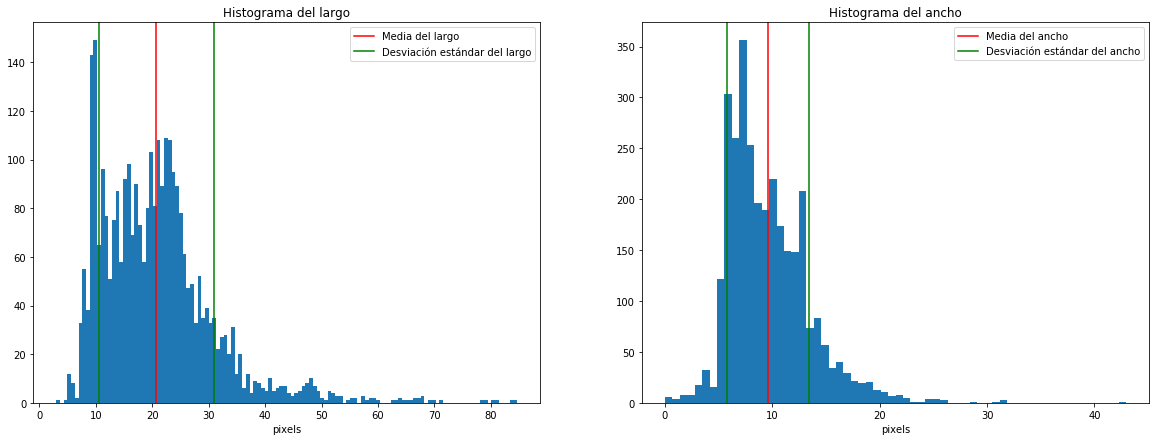

In [12]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.hist(d[:,0],bins=len(dims)//50) 
plt.title("Histograma del largo") 
plt.xlabel('pixels')
l1 = plt.axvline(mean_len, c='r')
l2 = plt.axvline(mean_len+std_len, c='g')
l3 = plt.axvline(mean_len-std_len, c='g')
plt.legend((l1, l2, l3), ['Media del largo', 'Desviación estándar del largo'])

plt.subplot(122)
plt.hist(d[:,1],bins=len(dims)//100) 
plt.title("Histograma del ancho") 
plt.xlabel('pixels')
l1 = plt.axvline(mean_width, c='r')
l2 = plt.axvline(mean_width+std_width, c='g')
l3 = plt.axvline(mean_width-std_width, c='g')
plt.legend((l1, l2, l3), ['Media del ancho', 'Desviación estándar del ancho'])
plt.show()

In [11]:
mean = np.mean(d,axis=0)
print("mean:",mean)

cov = np.cov(d[:,0],d[:,1])
print("cov:",cov)


mean: [20.7247332   9.61818939]
cov: [[103.80124818  21.61793687]
 [ 21.61793687  14.59060681]]
